### 1) ABSTACTO E INTRODUCCION DEL PROYECTO:
> 
### Se trabajará con datos de consumo energetico de aparatos electronicos de una vivienda (heladera, lavarropas, hornos, TV, Lavavajillas, etc), junto con mediciones ambientales internas y externas, generadas por una red de sensores wireless distribuidos en distintos puntos de la vivienda, para generar un programa de prediccion de consumos.   
> 
#### Algunas ventajas de la prediccion de consumos:
#####       -Las empresas y los usuarios residenciales pueden convertir la cantidad de energía consumida en valor monetario y por lo tanto, estimar la factura de energía y tomar decisiones basadas en estos datos.  
#####       -Práctica: No sólo sirve para saber cuánta energía se consume, sino también para entender cómo y porqué. De esta manera se pueden cambiar hábitos sin afectar la productividad o la calidad de vida.  
#####       -Técnica: Una mejor gestión de los datos de energía permite la recopilación y el análisis de dichos datos, así como la obtención de predicciones más precisas.  
> 
### A continuacion se describen el contexto empresarial, problema comercial principal y el contexto analitico, para posteriormente introducir los datos y su analisis exploratorio.
>
**Contexto comercial:**  

Se trabaja sobre un proyecto de asesoria para gestion de consumo en hogares, con el objetivo es desarrollar un sistema de medicion de parametros dentro y fuera del hogar, y por medio de machine learning, generar las mejores predicciones posibles. Esto permitirá por medio de mediciones relativamente simples, y sin considerar la complejidad que implicaria caracterizar la totalidad de artefactos que pudiesen influir en el consumo, tener una prevision de los consumos. Dicha estimacion podrá ser tan importante para el usuario para registrar y administrar sus propios consumos, como asi tambien para el provedor del servicio de electricida (una vez que exista un campo instalado lo suficientemente amplio como para generar predicciones por region).  Para este ulitmo caso podrian inclusive predecir fraude energetico, por ejemplo, detectar actuaciones y movimientos sobre la red de suministro no autorizados.   
Para ello, se hara un analisis exploratorio de datos y se probaran diferentes modelos hasta alcanzar un predictor que arroje la menor varianza posible. 
> 
**Problema comercial:**

Al dia de la fecha no hay un sistema que permita generar predicciones de este tipo, por lo tanto, es tarea de la asesoria encontrar patrones entre las variables medidas, seleccionar cuales son relevantes y cuales no, y a traves de ellas testear modelos de prediccion que arrojen resultados con el menor error posible.
> 
**Contexto analítico:**   

Los datos recolectados corresponden a mediciones realizados en un hogar ***X** durante el año 2016 desde Enero a Diciembre, y variables ambientales del sistema meteorologico local. La energia (en Wh) junto con el resto de los parametros fueron almacenados cada 10 minutos, lo suficientemente largo como para que el consumo de estos artefactos de medicion sea minimo, pero tambien lo mas acotado poosible para detectar cambios rapidos en el consumo de la energia. Ademas de las mediciones globales de energia y parametros tales como la Temperatura y humedad ambientales, se ha adicionado el consumo de luminarias que ademas de los Wh que registren, son un buen indicador del nivel de ocupacion de la vivienda.  

Para mas detalles de las variables medidas se puede ver el Glorasio al pie de cada Notebook. A modo de resumen del dataset, se puede ver que cuenta con un total de 29 Variables y 19.735 mediciones efectuadas durante ese año.  

El problema a priori podria ser abordado por medio de tecnicas de regresion una vez escogidas las variables mas relevantes.  

El caso se estructura de la siguiente manera, vamos a:
1. realizar análisis de datos exploratorios para investigar visualmente la estructura de los datos.  
2. utilizar estas observaciones para guiar nuestra metodología de agrupamiento y ajustar los modelos adecuados.
3. generar modelos escogidos (**NO INCLUIDO EN ESTA ENTREGA**) con un 70% de las filas del dataset (elegidas aleatoriamente por mes para evitar sesgos de estacionalidad, dado que tenemos el consumo de un año solamente) y testearlos contra el 30% restante  



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import scipy

In [2]:
df_energia_hogar = pd.read_csv('C:/Users/javie/Documents/DATA SCIENCE/0. CODERHOUSE - DS/CLASES/Entregables/energydata_complete.csv')
print(df_energia_hogar.head(5))
df_energia_hogar.shape

#date esta en formato string: transformo a datetime
df_energia_hogar['date'] = pd.to_datetime(df_energia_hogar['date'], errors='coerce')
#df_energia_hogar.info()
df_energia_hogar.columns

# Describo brevemente la variable de interes ('Appliances': consumo en Wh) y date, para tener un panorama  
# global del conjunto de datos a trabajar:
Describe_Wh = df_energia_hogar['Appliances'].describe()
display(Describe_Wh)
Describe_date = df_energia_hogar['date'].describe()
display(Describe_date)

               date  Appliances  lights     T1       RH_1    T2       RH_2  \
0  11-01-2016 17:00          60      30  19.89  47.596667  19.2  44.790000   
1  11-01-2016 17:10          60      30  19.89  46.693333  19.2  44.722500   
2  11-01-2016 17:20          50      30  19.89  46.300000  19.2  44.626667   
3  11-01-2016 17:30          50      40  19.89  46.066667  19.2  44.590000   
4  11-01-2016 17:40          60      40  19.89  46.333333  19.2  44.530000   

      T3       RH_3         T4  ...         T9   RH_9  T_out  Press_mm_hg  \
0  19.79  44.730000  19.000000  ...  17.033333  45.53   6.60        733.5   
1  19.79  44.790000  19.000000  ...  17.066667  45.56   6.48        733.6   
2  19.79  44.933333  18.926667  ...  17.000000  45.50   6.37        733.7   
3  19.79  45.000000  18.890000  ...  17.000000  45.40   6.25        733.8   
4  19.79  45.000000  18.890000  ...  17.000000  45.40   6.13        733.9   

   RH_out  Windspeed  Visibility  Tdewpoint        rv1        rv2  


count    19735.000000
mean        97.694958
std        102.524891
min         10.000000
25%         50.000000
50%         60.000000
75%        100.000000
max       1080.000000
Name: Appliances, dtype: float64

<ipython-input-2-1b1875912cd9>:14: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  Describe_date = df_energia_hogar['date'].describe()


count                   19735
unique                  19735
top       2016-11-01 17:00:00
freq                        1
first     2016-01-02 00:00:00
last      2016-12-05 23:50:00
Name: date, dtype: object

In [3]:
#Segmento variables horarias segun dia, mes y horario.
df_energia_hogar['day'] = pd.to_datetime(df_energia_hogar['date']).dt.date
df_energia_hogar['time'] = pd.to_datetime(df_energia_hogar['date']).dt.time
df_energia_hogar['month'] = pd.to_datetime(df_energia_hogar['date']).dt.month 
#Defino Dias de la Semana: Puede ser util si quiero analizar que sucede los fines de semana y el resto de dias 
df_energia_hogar['day of the week'] = df_energia_hogar.date.dt.day_name()
def set_values(row, value):
    return value[row]
map_dictionary ={'Monday' : "workday", 'Tuesday' :"workday", 'Wednesday' : "workday", 'Thursday' :"workday", 'Friday' : "workday",'Saturday':"weekend",'Sunday':"weekend"} 
df_energia_hogar['Type day'] = df_energia_hogar['day of the week'].apply(set_values, args =(map_dictionary, )) 

#Defino sobre el DS dias laborables y fines de semana
df_energia_hogar_workday = df_energia_hogar[df_energia_hogar['Type day'] != 'weekend'] 
df_energia_hogar_weekend = df_energia_hogar[df_energia_hogar['Type day'] != 'workday']
#Elimino Variables Random (r1,r2)
del df_energia_hogar['rv1']
del df_energia_hogar['rv2']

display(df_energia_hogar)

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,day,time,month,day of the week,Type day
0,2016-11-01 17:00:00,60,30,19.890000,47.596667,19.200000,44.790000,19.790000,44.730000,19.000000,...,733.5,92.000000,7.000000,63.000000,5.3,2016-11-01,17:00:00,11,Tuesday,workday
1,2016-11-01 17:10:00,60,30,19.890000,46.693333,19.200000,44.722500,19.790000,44.790000,19.000000,...,733.6,92.000000,6.666667,59.166667,5.2,2016-11-01,17:10:00,11,Tuesday,workday
2,2016-11-01 17:20:00,50,30,19.890000,46.300000,19.200000,44.626667,19.790000,44.933333,18.926667,...,733.7,92.000000,6.333333,55.333333,5.1,2016-11-01,17:20:00,11,Tuesday,workday
3,2016-11-01 17:30:00,50,40,19.890000,46.066667,19.200000,44.590000,19.790000,45.000000,18.890000,...,733.8,92.000000,6.000000,51.500000,5.0,2016-11-01,17:30:00,11,Tuesday,workday
4,2016-11-01 17:40:00,60,40,19.890000,46.333333,19.200000,44.530000,19.790000,45.000000,18.890000,...,733.9,92.000000,5.666667,47.666667,4.9,2016-11-01,17:40:00,11,Tuesday,workday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19730,2016-05-27 17:20:00,100,0,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.700000,...,755.2,55.666667,3.333333,23.666667,13.3,2016-05-27,17:20:00,5,Friday,workday
19731,2016-05-27 17:30:00,90,0,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.700000,...,755.2,56.000000,3.500000,24.500000,13.3,2016-05-27,17:30:00,5,Friday,workday
19732,2016-05-27 17:40:00,270,10,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.700000,...,755.2,56.333333,3.666667,25.333333,13.3,2016-05-27,17:40:00,5,Friday,workday
19733,2016-05-27 17:50:00,420,10,25.500000,46.990000,25.414000,43.036000,26.890000,41.290000,24.700000,...,755.2,56.666667,3.833333,26.166667,13.2,2016-05-27,17:50:00,5,Friday,workday


Descripcion breve de la muestra, valores maximos, estadisticas y localizacion de valores NaN 

In [4]:
df_energia_hogar.max()

date               2016-12-05 23:50:00
Appliances                        1080
lights                              70
T1                               26.26
RH_1                             63.36
T2                           29.856667
RH_2                         56.026667
T3                              29.236
RH_3                         50.163333
T4                                26.2
RH_4                             51.09
T5                              25.795
RH_5                         96.321667
T6                               28.29
RH_6                              99.9
T7                                26.0
RH_7                              51.4
T8                               27.23
RH_8                             58.78
T9                                24.5
RH_9                         53.326667
T_out                             26.1
Press_mm_hg                      772.3
RH_out                           100.0
Windspeed                         14.0
Visibility               

In [5]:
df_energia_hogar.isnull().describe()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,day,time,month,day of the week,Type day
count,19735,19735,19735,19735,19735,19735,19735,19735,19735,19735,...,19735,19735,19735,19735,19735,19735,19735,19735,19735,19735
unique,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
top,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
freq,19735,19735,19735,19735,19735,19735,19735,19735,19735,19735,...,19735,19735,19735,19735,19735,19735,19735,19735,19735,19735


In [6]:
for column in df_energia_hogar.columns:
    print(column, df_energia_hogar[column].nunique())

date 19735
Appliances 92
lights 8
T1 722
RH_1 2547
T2 1650
RH_2 3376
T3 1426
RH_3 2618
T4 1390
RH_4 2987
T5 2263
RH_5 7571
T6 4446
RH_6 9708
T7 1955
RH_7 5891
T8 2228
RH_8 6649
T9 924
RH_9 3388
T_out 1055
Press_mm_hg 2189
RH_out 566
Windspeed 189
Visibility 412
Tdewpoint 1118
day 138
time 144
month 12
day of the week 7
Type day 2


In [7]:
df_energia_hogar.isna().sum()

date               0
Appliances         0
lights             0
T1                 0
RH_1               0
T2                 0
RH_2               0
T3                 0
RH_3               0
T4                 0
RH_4               0
T5                 0
RH_5               0
T6                 0
RH_6               0
T7                 0
RH_7               0
T8                 0
RH_8               0
T9                 0
RH_9               0
T_out              0
Press_mm_hg        0
RH_out             0
Windspeed          0
Visibility         0
Tdewpoint          0
day                0
time               0
month              0
day of the week    0
Type day           0
dtype: int64

De la descripcion anterior se ve que no hay datos nulos. 

#  ANALISIS EXPLORATORIO DE DATOS (EDA)


### GRAFICOS INTERES SOBRE EL CONSUMO ('Appliance' en Wh)


(0.0, 200.0)

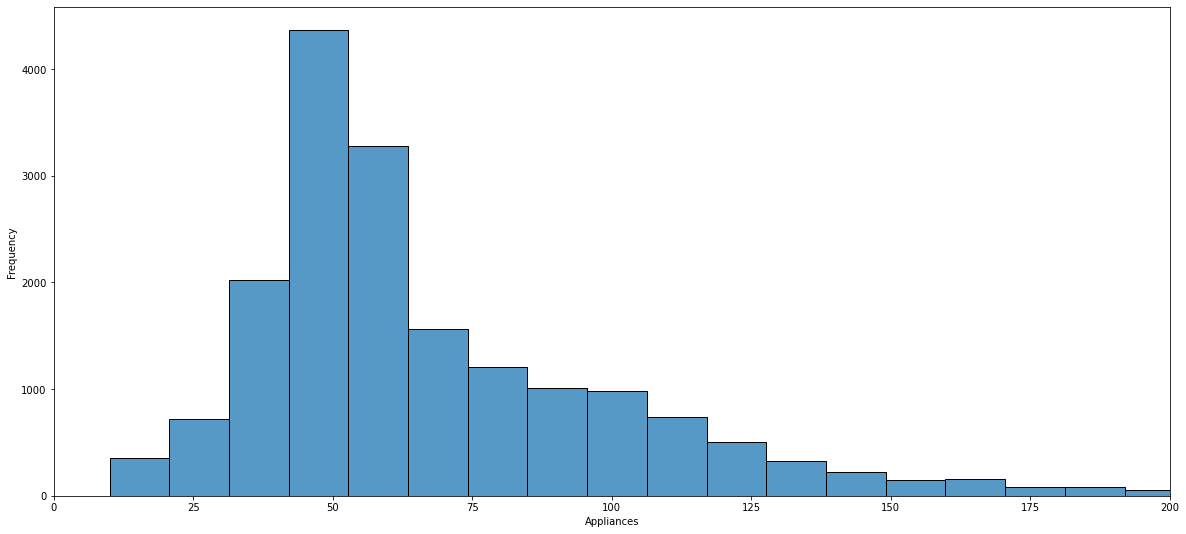

In [8]:
# Histograma del total de mediciones de consumo:  
fig, ax = plt.subplots()
fig.set_size_inches((20,9))
sns.histplot(data=df_energia_hogar, x="Appliances", bins=100)
ax.set_ylabel('Frequency')
ax.set_xlabel('Appliances')
plt.xlim(0, 200)

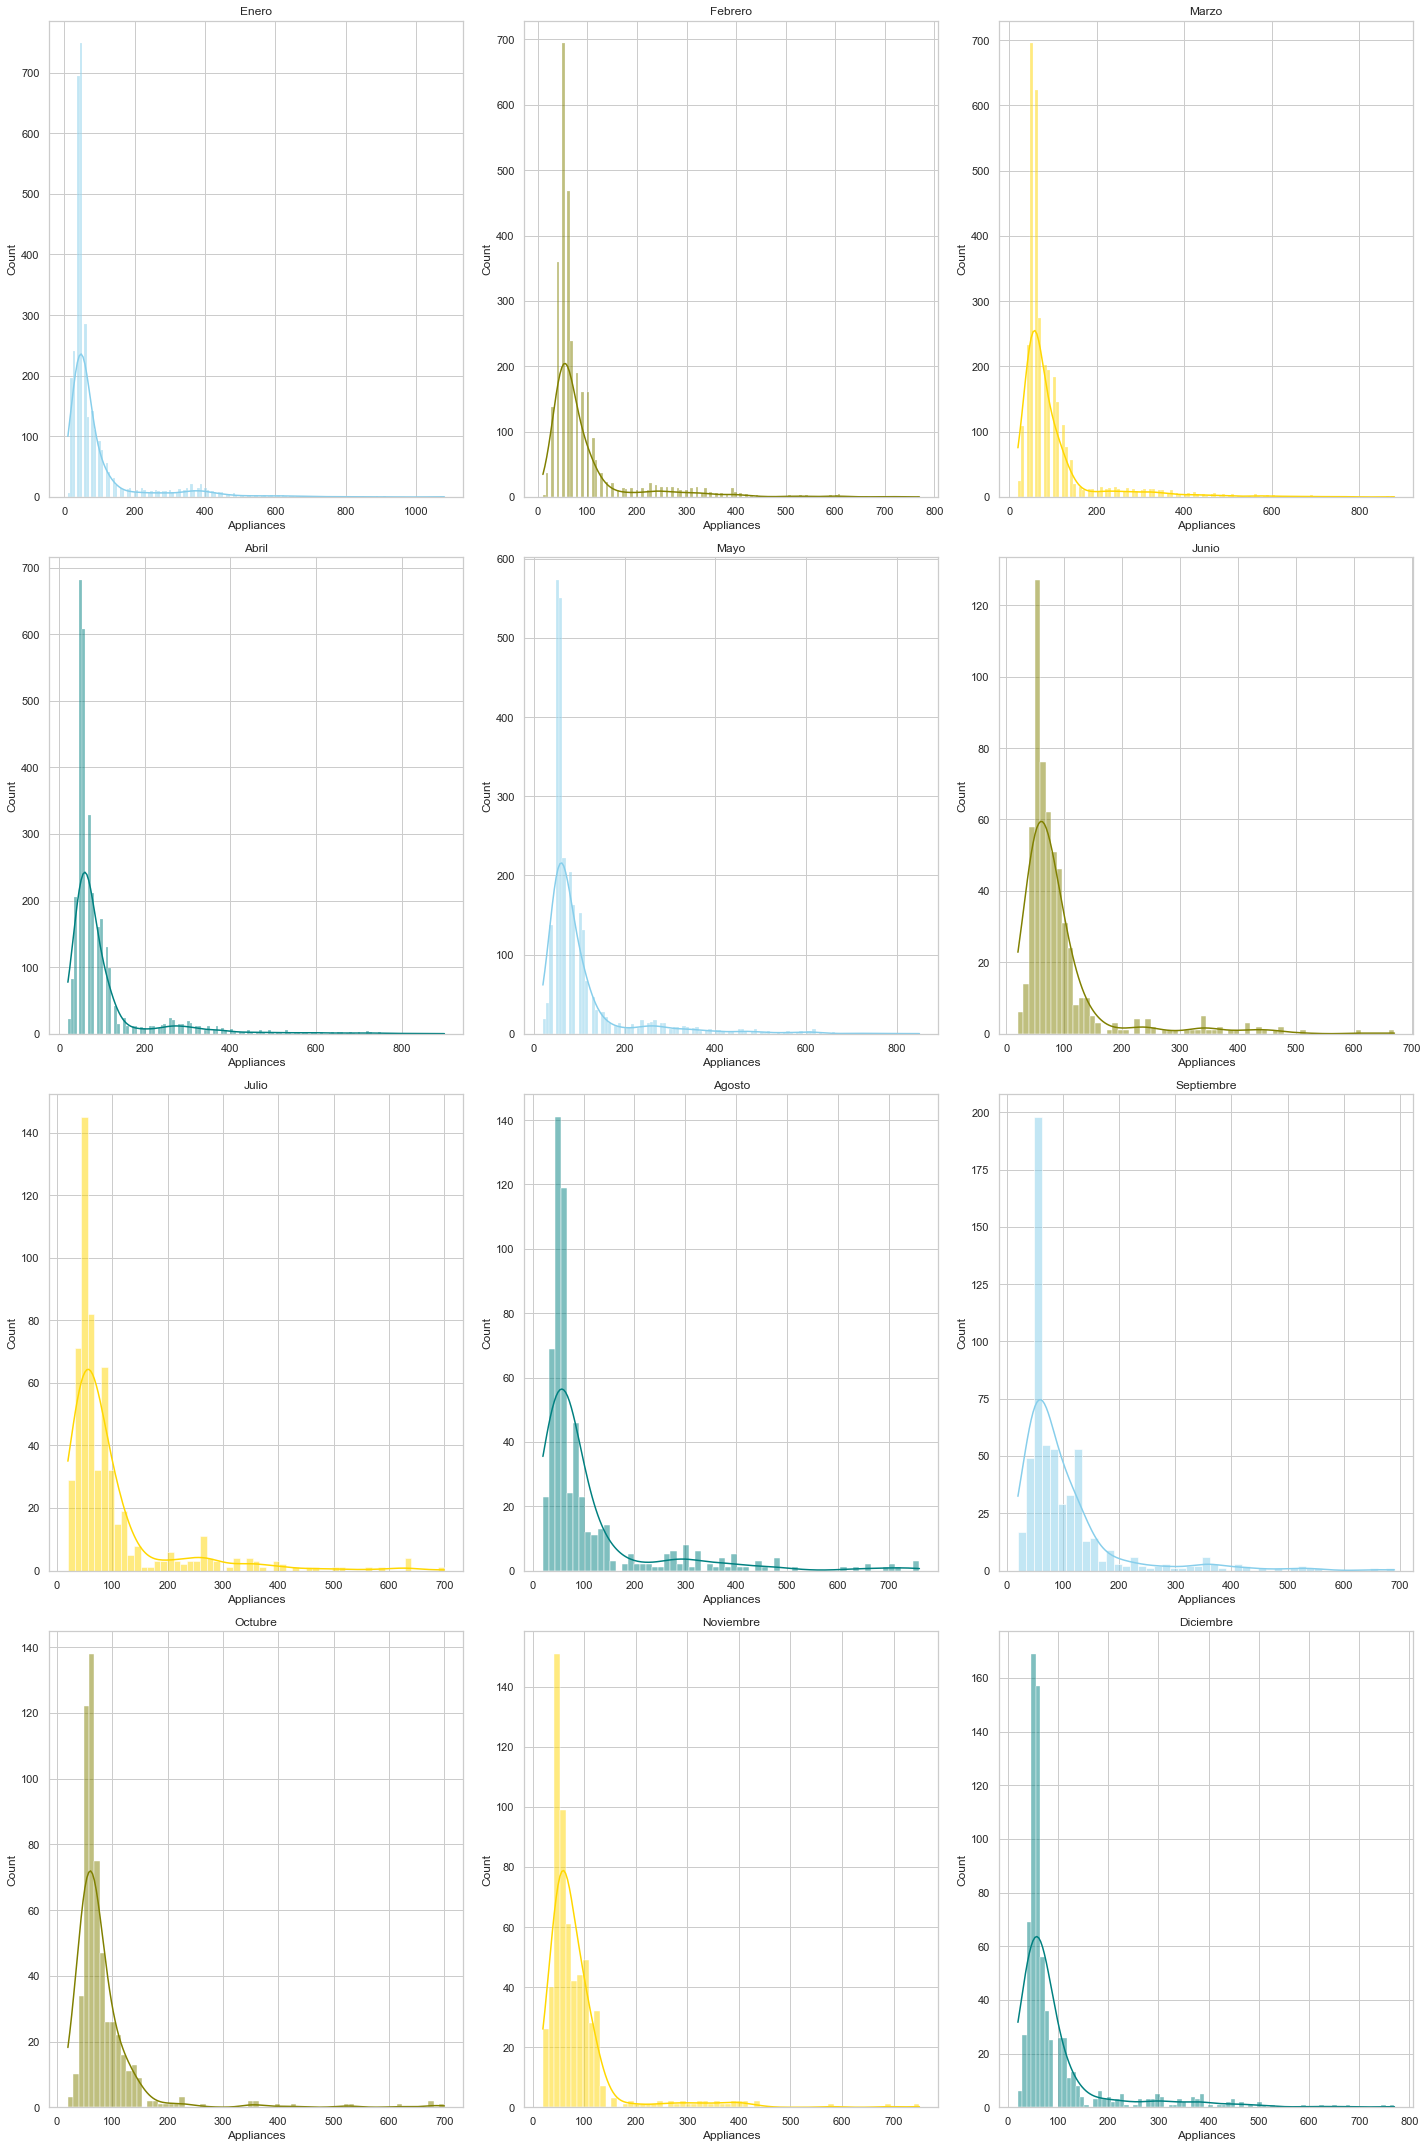

In [9]:
# Histogramas mensuales:  
df_month = df_energia_hogar[['Appliances','month']]
# df_ene = df_month.loc[(df_energia_hogar['month'] == 1)]
sns.set(style="whitegrid")  
fig,axs = plt.subplots(4,3, figsize = (20,30))
sns.histplot(data=df_month.loc[(df_energia_hogar['month'] == 1)], x="Appliances", kde=True, color="skyblue", ax=axs[0,0]).set(title='Enero')
sns.histplot(data=df_month.loc[(df_energia_hogar['month'] == 2)], x="Appliances", kde=True, color="olive", ax=axs[0,1]).set(title='Febrero')
sns.histplot(data=df_month.loc[(df_energia_hogar['month'] == 3)], x="Appliances", kde=True, color="gold", ax=axs[0,2]).set(title='Marzo')
sns.histplot(data=df_month.loc[(df_energia_hogar['month'] == 4)], x="Appliances", kde=True, color="teal", ax=axs[1,0]).set(title='Abril')
sns.histplot(data=df_month.loc[(df_energia_hogar['month'] == 5)], x="Appliances", kde=True, color="skyblue", ax=axs[1,1]).set(title='Mayo')
sns.histplot(data=df_month.loc[(df_energia_hogar['month'] == 6)], x="Appliances", kde=True, color="olive", ax=axs[1,2]).set(title='Junio')
sns.histplot(data=df_month.loc[(df_energia_hogar['month'] == 7)], x="Appliances", kde=True, color="gold", ax=axs[2,0]).set(title='Julio')
sns.histplot(data=df_month.loc[(df_energia_hogar['month'] == 8)], x="Appliances", kde=True, color="teal", ax=axs[2,1]).set(title='Agosto')
sns.histplot(data=df_month.loc[(df_energia_hogar['month'] == 9)], x="Appliances", kde=True, color="skyblue", ax=axs[2,2]).set(title='Septiembre')
sns.histplot(data=df_month.loc[(df_energia_hogar['month'] == 10)], x="Appliances", kde=True, color="olive", ax=axs[3,0]).set(title='Octubre')
sns.histplot(data=df_month.loc[(df_energia_hogar['month'] == 11)], x="Appliances", kde=True, color="gold", ax=axs[3,1]).set(title='Noviembre')
sns.histplot(data=df_month.loc[(df_energia_hogar['month'] == 12)], x="Appliances", kde=True, color="teal", ax=axs[3,2]).set(title='Diciembre')
fig.tight_layout()


(0.0, 200.0)

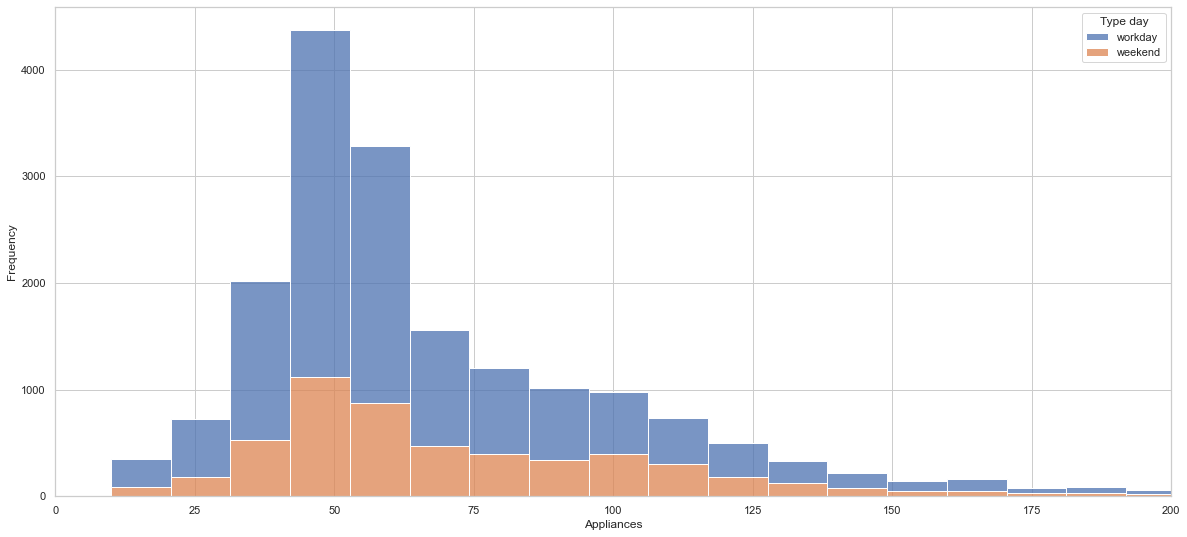

In [10]:
# Histogramas de consumo tipo de dia de la semana (laboral o fin de semana):  
fig, ax = plt.subplots()
fig.set_size_inches((20,9))
sns.histplot(data=df_energia_hogar, x="Appliances", hue="Type day", multiple="stack",bins=100)
ax.set_ylabel('Frequency')
ax.set_xlabel('Appliances')
plt.xlim(0, 200)



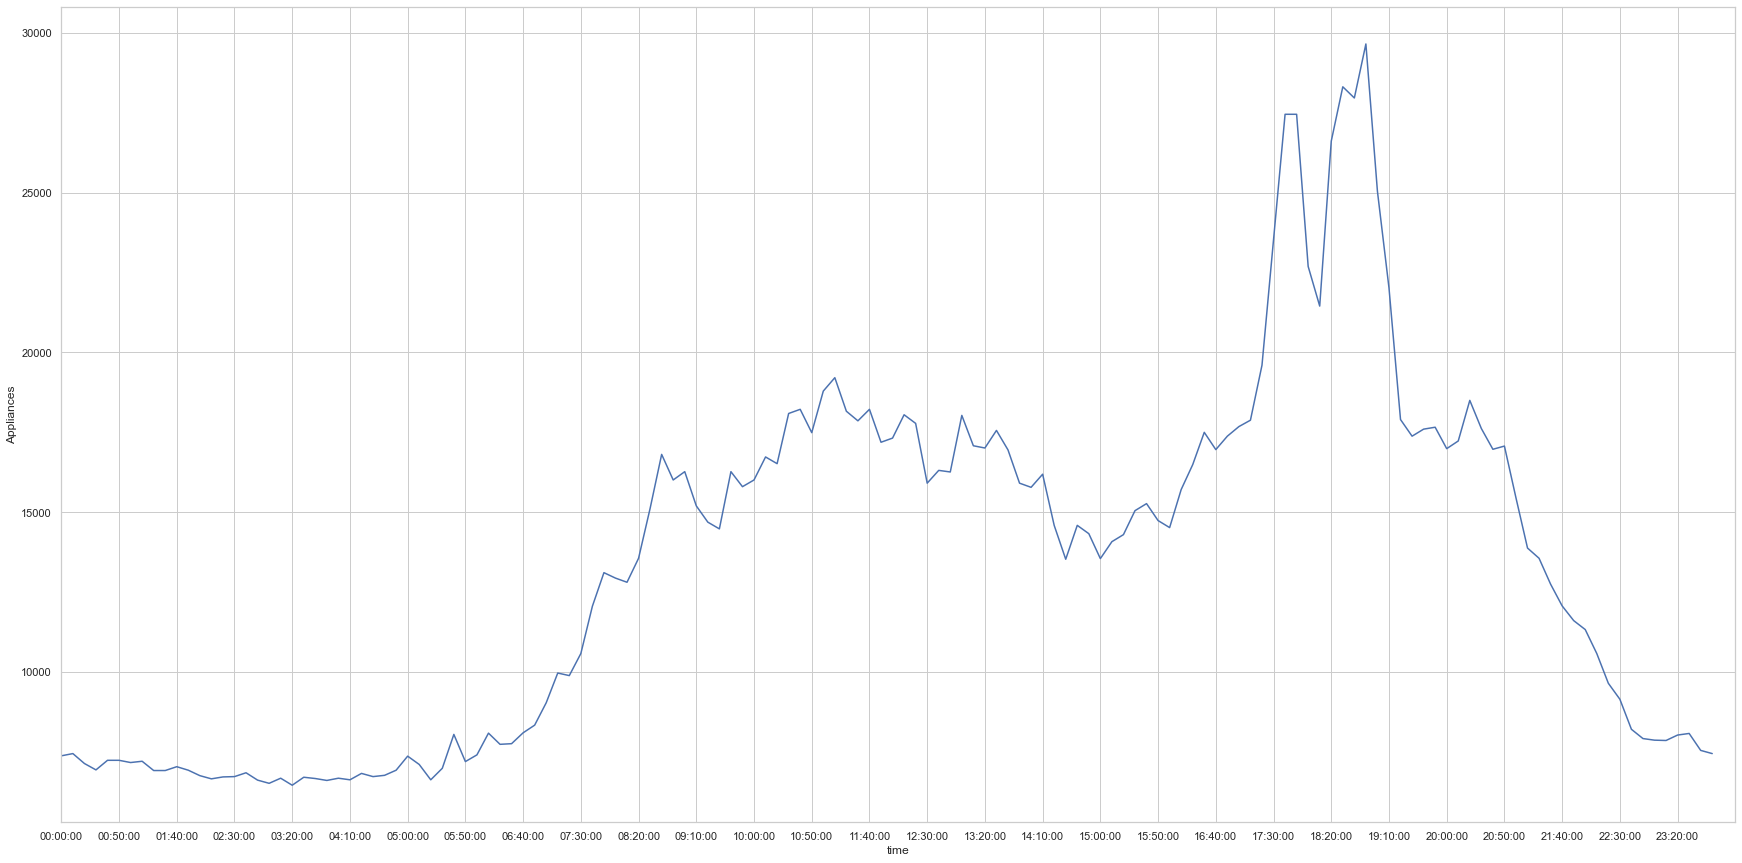

In [11]:
# Como es la variabilidad de los consumos en funcion del tiempo, que horarios presentan mayor consumo?
import datetime
df_time = df_energia_hogar[['Appliances','time']]
df_Time_Total_Appliances = df_time.groupby(by=["time"], dropna=False).sum().reset_index()
#Grafico consumos totales por hora durante el periodo de muestreo. Coincide con el maximo horario 
fig1, ax1 = plt.subplots()
fig1.set_size_inches((30,15)) 
sns.lineplot(data=df_Time_Total_Appliances, x=df_Time_Total_Appliances['time'].astype(str), y="Appliances")
ax1.set_xlim(0,145)
import matplotlib.ticker as ticker
ax1.xaxis.set_major_locator(ticker.MultipleLocator(5))

# Recordar que el maximo se registrò el 05 de Diciembre de 2016 a las 23:50:00

In [12]:
df_Time_Total_Appliances.describe()

,Appliances
count,144.000000
mean,13388.958333
std,5644.538758
min,6460.000000
25%,7450.000000
50%,14315.000000
75%,17200.000000
max,29650.000000


En el Lineplot de consumo total horario se acumula el total de consumo (independientemente del dia y estacion) por cada hora de muestreo. De este modo se puede observar que los picos de consumo se localizan entre las 17:00 y las 19:10 hs.   

Tambien se ve una gran acumulacion interesante de consumo durante la mañana y durante el mediodia pero con poca variacion horaria, mantiene una media de 16000 Wh acumulados hasta el pico de las  17 hs donde se alcanza un maximo de 29650 Wh

Text(0.5, 1.0, 'Appliances vs month')

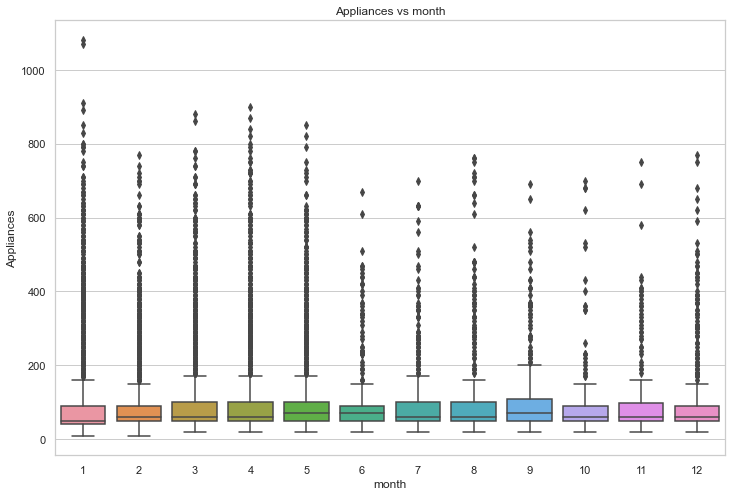

In [13]:
# Boxplot respecto a los meses del año
fig, ax = plt.subplots()
fig.set_size_inches((12,8))
sns.boxplot(x='month',y='Appliances',data=df_energia_hogar,ax=ax)
ax.set_ylabel('Appliances')
ax.set_xlabel('month')
ax.set_title('Appliances vs month')

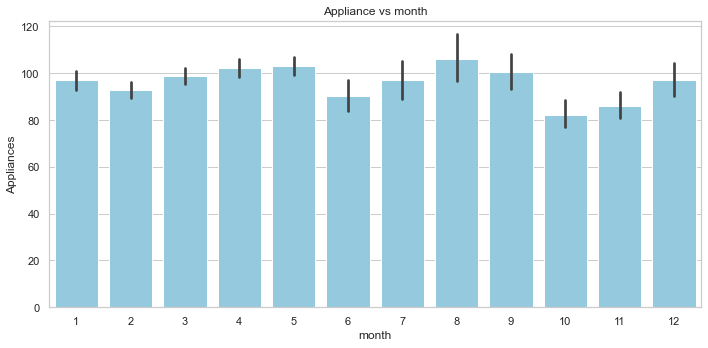

In [14]:
# BARPLOT POR MES

sns.set(style="whitegrid")  
fig,axs = plt.subplots(figsize = (10,5))
sns.barplot(data=df_energia_hogar, x="month",y="Appliances" , color="skyblue").set(title='Appliance vs month')
fig.tight_layout()


#### A partir de la funcion describe y de los graficos efectuados (histogramas, boxplot y de linea) se puede decir que:   

#### -Los valores mas frecuentes de consumo total en Wh (independientemente del mes) se encuentran entre 40-70 Wh, pero su valor medio es de 97,69 Wh, esto se debe a la dispersion que en algunos casos registra valores dos ordenes de magnitud mayores a la media de esta variable, siendo su desvio estandar de 102,52 Wh, y valor maximo en 1080 Wh.

#### -No hay variacion significativa los fines de semana respecto a los dias laborables. En terminos de la media existe un consumo levemente mas alto los fines de semana (10 Wh mas), que puede deberse a una permanencia mayor en la vivienda respecto a los dias laborables.  

#### -No se han observado variaciones estacionales significativas, dado que tanto en los boxplot mensuales como en los histogramas el pico se mantiene en el mismo rango de valores.   
#### Analizando tanto el boxplot como el barplot por mes se observa que los outliers son relevantes y afectan al consumo total considerablemente 

#### -Si se toma el grafico de linea horario considerando la suma de los consumos registrados en la hora de medicion durante todo el periodo de muestreo, se ve que el consumo se mantiene estable la mayor parte del dia con una media de 16000 Wh acumulados hasta el pico de las  17 hs donde se alcanza un maximo de 29650 Wh (localizado entre las 17:00 hs y las 19:10 hs)


### HEATMAP Y CORRELACIONES


<ipython-input-15-7fa30f876378>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data=df_energia_hogar.corr(), cmap='Blues')


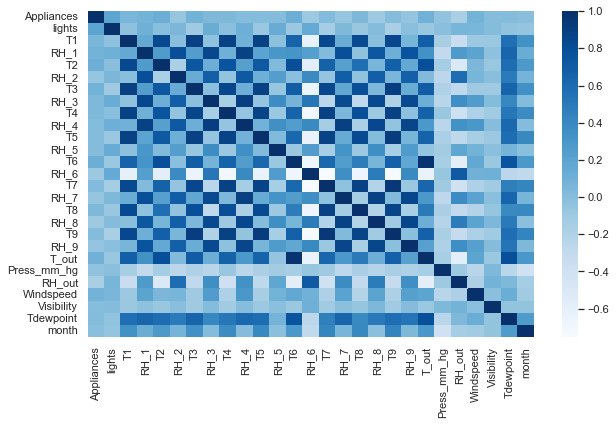

In [15]:
# Heatmap de la libreria Seaborn:  
plt.figure(figsize=(10,6))
sns.heatmap(data=df_energia_hogar.corr(), cmap='Blues')


In [16]:
# Resumen numerico de las correlaciones halladas en el heatmap: 
df_energia_hogar.corr()

<ipython-input-16-3a01b99e2ac9>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_energia_hogar.corr()


,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,month
Appliances,1.000000,0.197278,0.055447,0.086031,0.120073,-0.060465,0.085060,0.036292,0.040281,0.016965,...,-0.094039,0.010010,-0.051462,0.099155,-0.034885,-0.152282,0.087122,0.000230,0.015357,-0.006745
lights,0.197278,1.000000,-0.023528,0.106968,-0.005622,0.050985,-0.097393,0.131161,-0.008859,0.114936,...,0.012915,-0.157592,-0.008766,-0.074423,-0.010576,0.068543,0.060281,0.020038,-0.036331,-0.050865
T1,0.055447,-0.023528,1.000000,0.164006,0.836834,-0.002509,0.892402,-0.028550,0.877001,0.097861,...,-0.006441,0.844777,0.071756,0.682854,-0.150574,-0.345481,-0.087654,-0.076210,0.571333,0.335936
RH_1,0.086031,0.106968,0.164006,1.000000,0.269839,0.797535,0.253230,0.844677,0.106180,0.880359,...,0.736196,0.115263,0.764001,0.340788,-0.293957,0.274126,0.204932,-0.021057,0.639125,0.134118
T2,0.120073,-0.005622,0.836834,0.269839,1.000000,-0.165610,0.735245,0.121497,0.762066,0.231563,...,0.068534,0.675535,0.157346,0.792247,-0.133028,-0.505291,0.052495,-0.069721,0.582632,0.286658
RH_2,-0.060465,0.050985,-0.002509,0.797535,-0.165610,1.000000,0.137319,0.678326,-0.047304,0.721435,...,0.679777,0.054544,0.676467,0.033703,-0.255646,0.584911,0.069190,-0.005368,0.499154,0.075489
T3,0.085060,-0.097393,0.892402,0.253230,0.735245,0.137319,1.000000,-0.011234,0.852778,0.122737,...,0.044427,0.901324,0.134602,0.699420,-0.189974,-0.281718,-0.100776,-0.102310,0.645909,0.346614
RH_3,0.036292,0.131161,-0.028550,0.844677,0.121497,0.678326,-0.011234,1.000000,-0.140457,0.898978,...,0.828822,-0.195270,0.833538,0.118237,-0.233274,0.356192,0.263188,0.017041,0.414398,0.016185
T4,0.040281,-0.008859,0.877001,0.106180,0.762066,-0.047304,0.852778,-0.140457,1.000000,-0.048650,...,-0.095192,0.889439,-0.025549,0.663479,-0.075292,-0.388602,-0.185747,-0.104768,0.519504,0.382177
RH_4,0.016965,0.114936,0.097861,0.880359,0.231563,0.721435,0.122737,0.898978,-0.048650,1.000000,...,0.847259,-0.044518,0.856591,0.293307,-0.250748,0.336813,0.300192,0.002636,0.616508,0.008766


In [17]:
# Correlaciones mas importantes: 

df_correlaciones = df_energia_hogar.drop(columns=['date', 'day', 'time', 'month', 'day of the week', 'Type day'])


def parejas(df_correlaciones):
    '''Obtiene diagonal inferior de parejas en matriz de correlacion'''
    pairs_to_drop = set()
    cols = df_correlaciones.columns
    for i in range(0, df_correlaciones.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def correlaciones(data, n=5):
    au_corr = data.corr().abs().unstack()
    labels_to_drop = parejas(data)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Correlaciones mas grandes")
print(correlaciones(df_correlaciones, 25)) # Saquemos el top 10

Correlaciones mas grandes
T6    T_out    0.974778
T7    T9       0.944776
T5    T9       0.911055
T3    T9       0.901324
RH_3  RH_4     0.898978
RH_4  RH_7     0.894301
T1    T3       0.892402
T4    T9       0.889439
T3    T5       0.888169
T1    T5       0.885247
RH_7  RH_8     0.883984
T7    T8       0.882123
RH_1  RH_4     0.880359
T4    T7       0.877763
T1    T4       0.877001
T4    T5       0.871813
T5    T7       0.870624
T8    T9       0.869338
RH_7  RH_9     0.858686
RH_4  RH_9     0.856591
RH_8  RH_9     0.855812
T3    T4       0.852778
      T7       0.847374
RH_4  RH_8     0.847259
T1    T9       0.844777
dtype: float64


####  Existen correlaciones posivas entre el consumo y el resto de variables. De los resultados del Heatmap y el resumen numerico de correlaciones se observan varias correlaciones positivas entre Appliances pero con valores bajos:   
            -Lights (+0.19)  
            -T2 (+0.12)  
            -T6 (+0.12)  
            -T_out(+0.10)  
            -Windspeed (+0.09)  
            

#### PAIRPLOT

In [35]:
#Visualizamos las relación par-par entre variables
# primero depuro el DS con las variables medidas y el mes:
# Genero 3 set de datos con para agrupar las variables de catalogadas entre 1 a 9:

# 'date', 'rv1', 'rv2', 'day', 'time', 'day of the week', 'Type day'
df_consumos = df_energia_hogar.drop(columns=['date', 'day', 'time', 'day of the week', 'month', 'Type day'])
# Descarto 7, 8 y 9

# Descarto 4, 5 y 6
df_consumos1 = df_energia_hogar.drop(columns=['T4','RH_4','T5','RH_5','T6','RH_6','date', 'day', 'time', 'day of the week', 'Type day'])
# Descarto 7, 8 y 9
df_consumos2 = df_energia_hogar.drop(columns=['T7','RH_7','T8','RH_8','T9','RH_9','date', 'day', 'time', 'day of the week', 'Type day'])
# Descarto 1, 2 y 3
df_consumos3 = df_energia_hogar.drop(columns=['Visibility','RH_out', 'Press_mm_hg','T7','RH_7','T8','RH_8','T9','RH_9','T1','RH_1','RH_2','T3','RH_3','T4','RH_4','T5','RH_5','RH_6','date', 'day', 'time', 'day of the week', 'Type day'])
# Realizo un pair plot con las variables que presentaron mejor correlacion posiva (lineal) con appliences:
# Lights (+0.19), T2 (+0.12), T6 (+0.12), T_out(+0.10)Windspeed (+0.09)  


<Figure size 720x432 with 0 Axes>

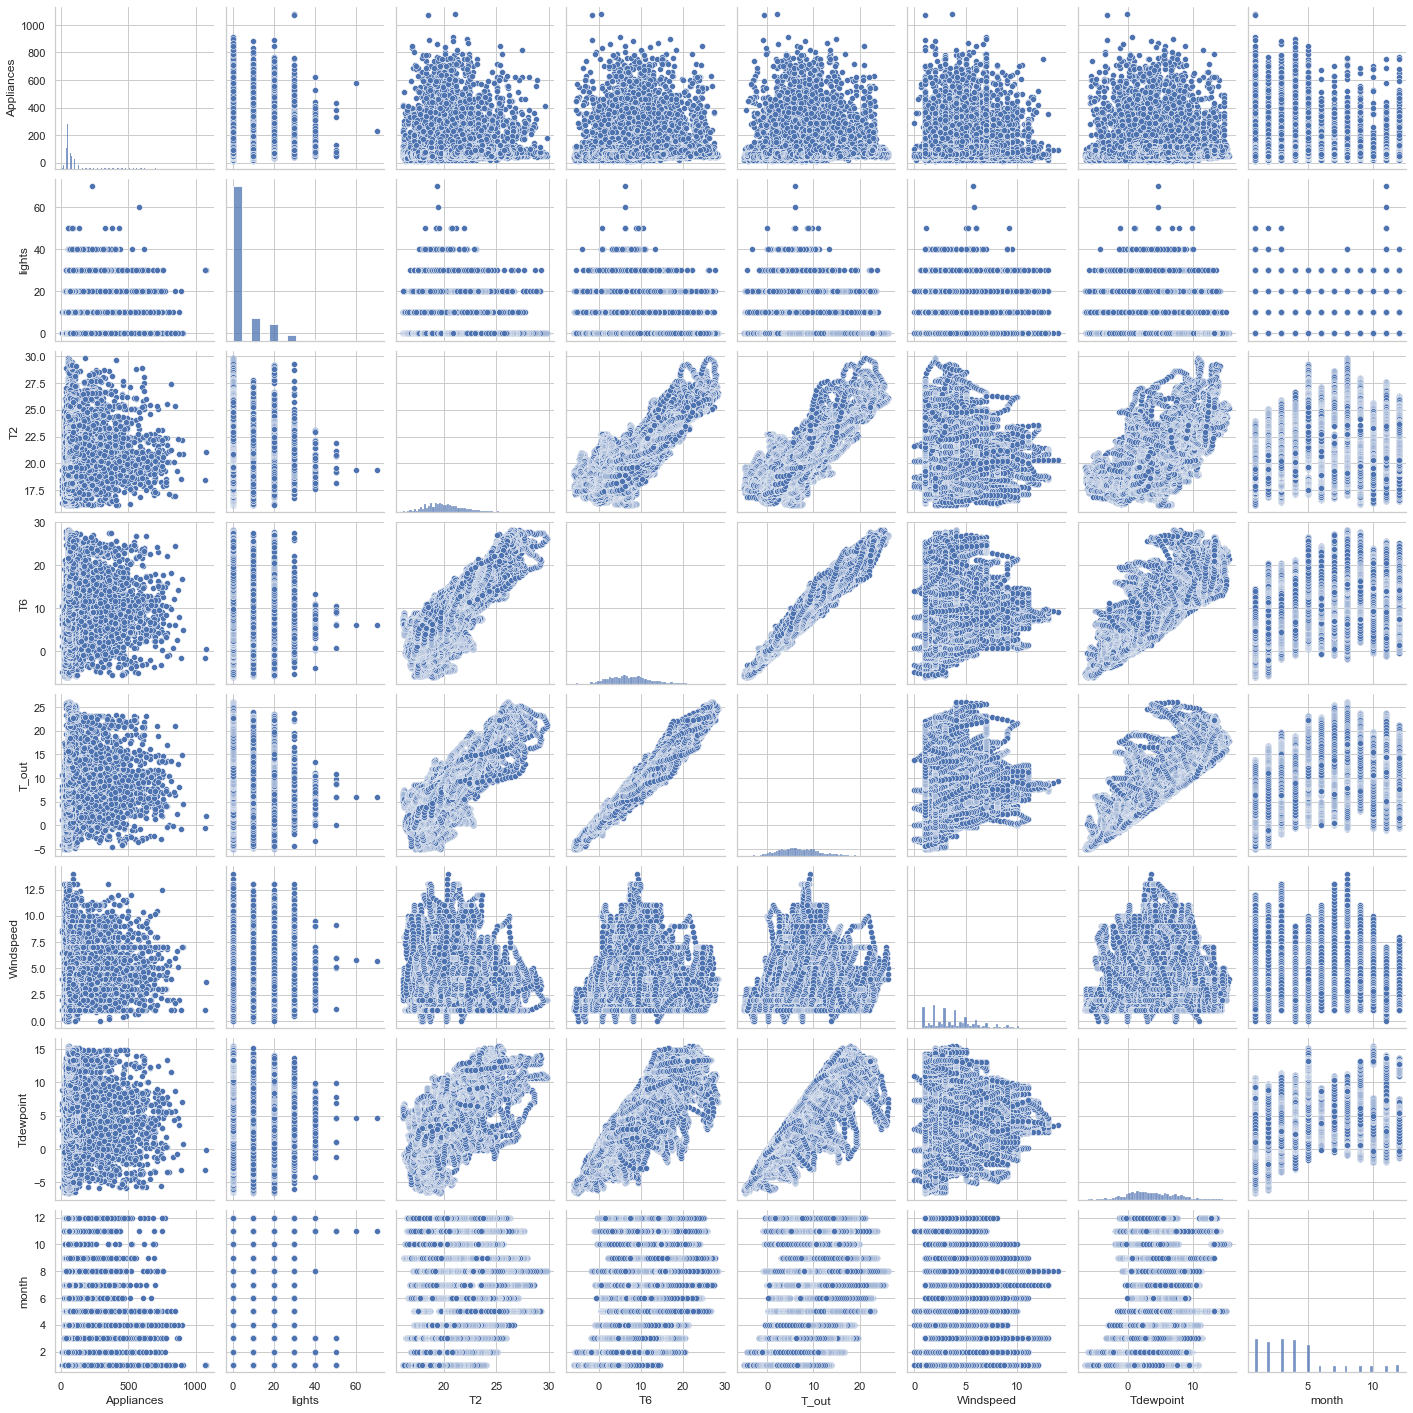

In [38]:
plt.figure(figsize=(10,6))
sns.pairplot(df_consumos3)
plt.show()

In [19]:
correlaciones(df_correlaciones).describe()

count    5.000000
mean     0.926182
std      0.032765
min      0.898978
25%      0.901324
50%      0.911055
75%      0.944776
max      0.974778
dtype: float64

### Seleccion de Variables de Interes:
#### A partir de una investigacion preliminar se pudo hallar un metodo para seleccion de variables mas importantes para un modelo de regresion o clasificaicon. No todas las variables serán igual de importantes para el modelo a entrenar, de hecho, tener un excedente de variables no relevantes puede afectar la eficiencia del modelo seleccionado.
>
#### Los metodos mas comunes para seleccion de variables son:
>
#### 1. BORUTA  (construido a partir de Random Forests). Puede ser usado sobre cualquier modelo de arbol: Random Forest, XGBoost, y Regresion Lineal.
>
#### 2. Light GBM (gradient boosting framework, 'potenciacion del gradiente')
>
#### 3. Chi Cuadrado

**1. BORUTA:**  
>
-Crea variables sombra, es decir, un nuevo setup de variables y los entrena sobre un Random Forest o XGBoost y calcula la importancia de cada variable a traves de la reduccion de la media de la impureza de Gini. 
>
-Chequea si hay variables reales con mayor importancia comparado con las variables sombra
>
-Repite la operacion por iteracion, si las variables originales tienen mejor performance las marca como importantes.



In [20]:
# Divido entre la variable dependiente (la que quiero predecir) y el resto de las variables
# Esto me dará el conjunto total de datos para el modelo
x = df_consumos.drop(columns=['Appliances'])
y = df_consumos['Appliances']


In [21]:
from sklearn.model_selection import train_test_split

In [22]:
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.3, random_state=0)
# 30% de datos para el test, y un valor de random state fijo (PARA QUE SIEMPRE TRABAJE CON EL MISMO CONJUNTO RANDOM)

In [23]:
import xgboost as xgb
model = xgb.XGBRegressor()
model.fit(X_train,Y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

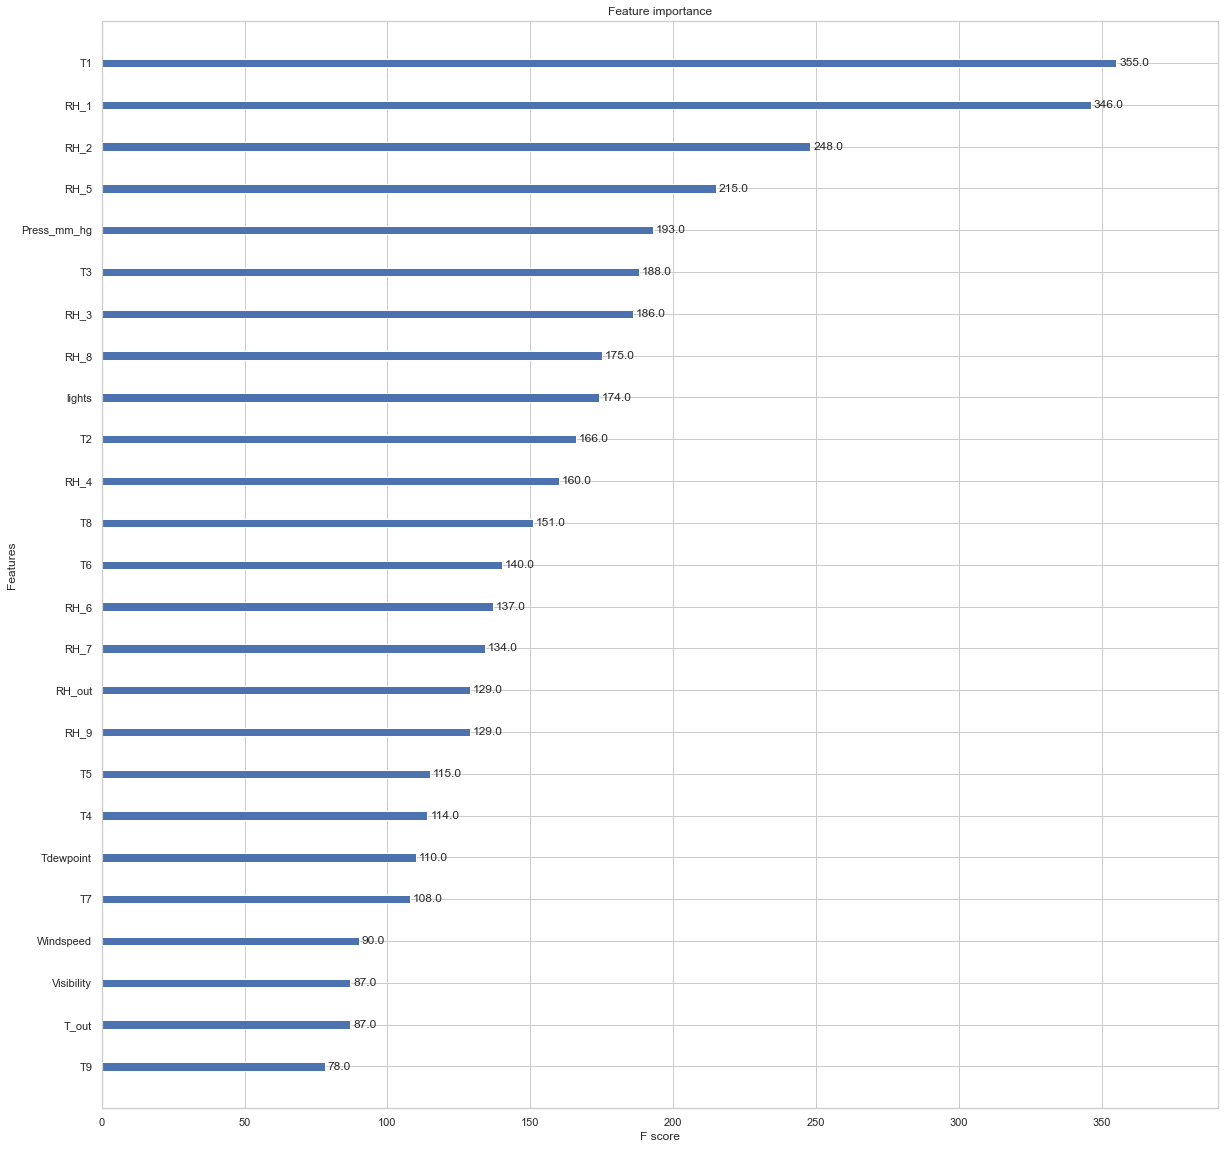

In [24]:
ax = xgb.plot_importance(model, ax=plt.gca())
fig = ax.figure
fig.set_size_inches(20, 20)

In [25]:
from boruta import BorutaPy
# Defino el selector de variables:
boruta_train = feature_selector = BorutaPy(model, n_estimators='auto', verbose=2, random_state=0)
# Que necesita el feature selector?:
# -Modelo elegido (definí como 'model' con xgb)
# -Puedo definir el numero de estimadores o de arboles (por ahora fijo automatico 'auto')
# -Puedo definir otros parametros, por el momento los dejo en default
boruta_train

BorutaPy(estimator=XGBRegressor(base_score=None, booster=None, callbacks=None,
                                colsample_bylevel=None, colsample_bynode=None,
                                colsample_bytree=None,
                                early_stopping_rounds=None,
                                enable_categorical=False, eval_metric=None,
                                feature_types=None, gamma=None, gpu_id=None,
                                grow_policy=None, importance_type=None,
                                interaction_constraints=None,
                                learning_rate=None, max_bin=None,
                                max_cat_threshold=None, max_cat_to_onehot=None,
                                max_delta_step=None, max_depth=None,
                                max_leaves=None, min_child_weight=None,
                                missing=nan, monotone_constraints=None,
                                n_estimators=100, n_jobs=None,
                                num_parallel_tree=None, predictor=None,
                                random_state=None, ...),
         n_estimators='auto', random_state=0, verbose=2)

In [26]:
# Primero debo convertir Y y X en Numpy Arrays para evitar error:
X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()
Y_train_np = Y_train.to_numpy()
Y_test_np = Y_test.to_numpy()
boruta_train.fit(X_train_np,Y_train_np)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	20
Tentative: 	5
Rejected: 	0
Iteration: 	9 / 100
Confirmed: 	20
Tentative: 	5
Rejected: 	0
Iteration: 	10 / 100
Confirmed: 	20
Tentative: 	5
Rejected: 	0
Iteration: 	11 / 100
Confirmed: 	20
Tentative: 	5
Rejected: 	0
Iteration: 	12 / 100
Confirmed: 	22
Tentative: 	3
Rejected: 	0
Iteration: 	13 / 100
Confirmed: 	22
Tentative: 	2
Rejected: 	1
Iteration: 	14 / 100
Confirmed: 	22
Tentative: 	2
Rejected: 	1
Iteration: 	15 / 100
Confirmed: 	22
Tentative: 	2
Rejected: 	1
Iteration: 	16 / 100
Confirmed: 	22
Tentative: 	2
Rejected: 	1
I

BorutaPy(estimator=XGBRegressor(base_score=None, booster=None, callbacks=None,
                                colsample_bylevel=None, colsample_bynode=None,
                                colsample_bytree=None,
                                early_stopping_rounds=None,
                                enable_categorical=False, eval_metric=None,
                                feature_types=None, gamma=None, gpu_id=None,
                                grow_policy=None, importance_type=None,
                                interaction_constraints=None,
                                learning_rate=None, max_bin=None,
                                max_cat_threshold=None, max_cat_to_onehot=None,
                                max_delta_step=None, max_depth=None,
                                max_leaves=None, min_child_weight=None,
                                missing=nan, monotone_constraints=None,
                                n_estimators=69, n_jobs=None,
                                num_parallel_tree=None, predictor=None,
                                random_state=1652416891, ...),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x1732A07EE40, verbose=2)

#### Identifico cuales variables son importantes y cuales no:


In [27]:
 boruta_train.support_
# True imporantes, False no importantes

array([ True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

In [28]:
#Cual es el ranking de las variables mas importantes?:
print('Ranking:',boruta_train.ranking_)

Ranking: [1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [29]:
selected_boruta = pd.DataFrame({'Variables':list(X_train.columns), 'Ranking':boruta_train.ranking_})
selected_boruta.sort_values(by='Ranking')

,Variables,Ranking
0,lights,1
22,Windspeed,1
21,RH_out,1
20,Press_mm_hg,1
19,T_out,1
18,RH_9,1
17,T9,1
16,RH_8,1
15,T8,1
14,RH_7,1


**Conclusion del analisis con Framework Boruta:**

De las 24 variables utilizadas (se descartaron previamente las variables categoricas y temporales), que se relacionan con el consumo total de energia en Wh existen 23 variables importantes segun modelo XGBoost, las cuales se enlistan en un Ranking con tun TOP5 conformado por las variables 'lights', 'Visibility', 'Windspeed', 'RH_out', 'Press_mm_hg'. Mostrando que el nivel de ocupacion de la vivienda como tambien los parametros ambientales exteriores influyen considerablemente en la variacion del consumo total en Wh ('Appliance')

# Glosario de variables:  

Appliances: energy use in Wh of appliances (variable target) 'Consumo de Aparatos Electronicos'   
lights: energy use of light fixtures in the house in Wh    
T1: Temperature in kitchen area, in Celsius  
RH_1:Humidity in kitchen area, in %  
T2:Temperature in living room area, in Celsius  
RH_2: Humidity in living room area, in %  
T3: Temperature in laundry room area  
RH_3: Humidity in laundry room area, in %  
T4: Temperature in office room, in Celsius  
RH_4: Humidity in office room, in %  
T5: Temperature in bathroom, in Celsius  
RH_5: Humidity in bathroom, in %  
T6: Temperature outside the building (north side), in Celsius  
RH_6: Humidity outside the building (north side), in %  
T7: Temperature in ironing room , in Celsius  
RH_7: Humidity in ironing room, in %  
T8:  Temperature in teenager room 2, in Celsius  
RH_8:  Humidity in teenager room 2, in %  
T9:  Temperature in parents room, in Celsius   
RH_9: Humidity in parents room, in %   
T_out: Temperature outside (from Chievres weather station), in Celsius  
Press_mm_hg: Pressure (from Chievres weather station), in mm Hg  
RH_out: Humidity outside (from Chievres weather station), in %  
Windspeed: Wind speed (from Chievres weather station), in m/s  
Visibility: Visibility (from Chievres weather station), in km  
Tdewpoint: Tdewpoint (from Chievres weather station), Â°C  
rv1: Random variable 1, nondimensional  
rv2: Random variable 2, nondimensional  
**Planta Baja:  
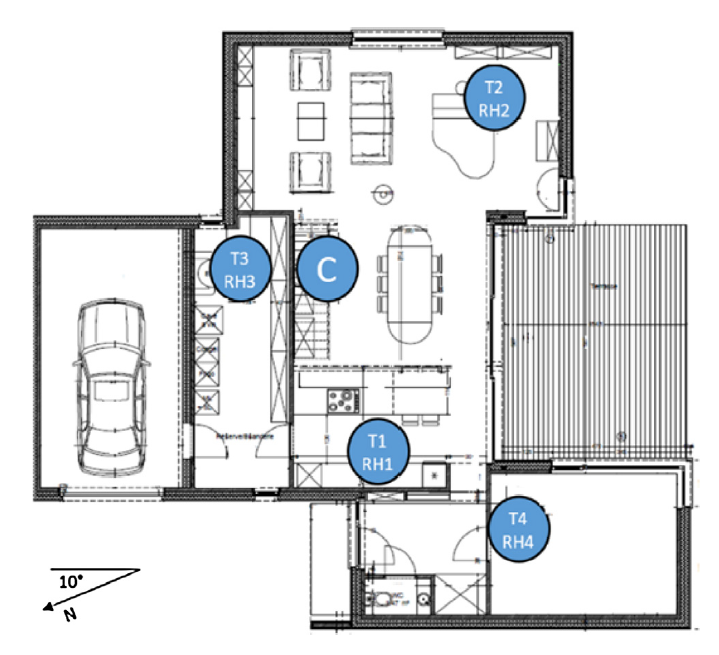
Planta Alta:  
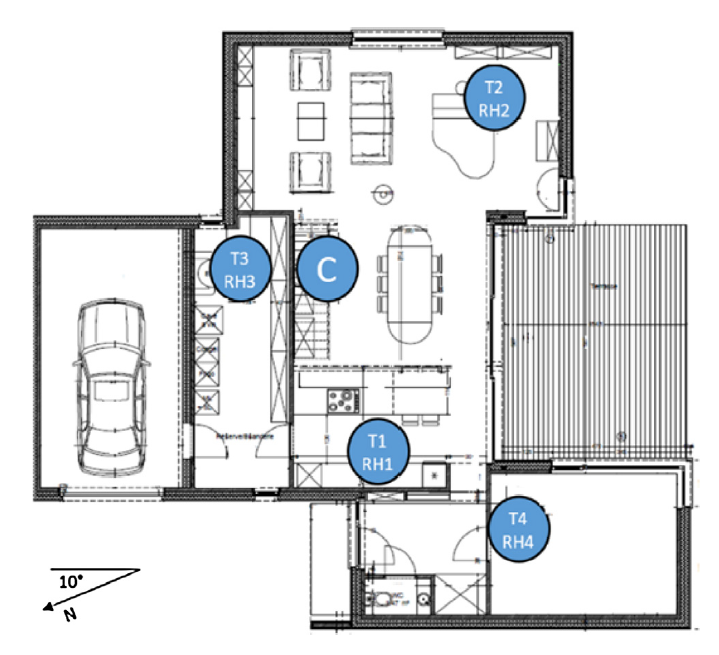
**

